# Benchmarking Transformers vs LSTM on Long Sequences (ETTh1 Dataset)

**Assignment - Comparative Analysis of Deep Learning Models**

**Dataset:** ETTh1 (Electricity Transformer Temperature - Hourly)
**Objective:** Compare Encoder-Decoder architectures for **Long-Sequence Time-Series Forecasting (LSTF)**.

Transformers are known to perform better than RNNs/LSTMs on long sequences due to their ability to capture long-range dependencies directly via attention mechanisms, whereas LSTMs suffer from gradient propagation issues over long horizons.

This is a physical system. While it has daily cycles, the deviations (residuals) are significant and driven by specific load events or cooling physics.

---

## Notebook Structure

1. **Setup and Imports**
2. **Dataset Loading (ETTh1)**
3. **Preprocessing (Long Sequences)**
4. **Seq2Seq Architecture Implementation**
   - Model A: LSTM Seq2Seq (Baseline)
   - Model B: Transformer with Multi-Head Attention
   - Model C: Transformer with Fourier Layer
   - Model D: Transformer with Sparse Attention (ProbSparse)
5. **Training and Evaluation**
6. **Comparative Analysis**

---


## 1. Setup and Imports


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import requests
from pathlib import Path

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# STL Decomposition
from statsmodels.tsa.seasonal import STL

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Seed
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Dataset Loading: ETTh1

The **ETTh1** (Electricity Transformer Temperature) dataset is a standard benchmark for Long-Sequence Time-Series Forecasting.
- **Target:** 'OT' (Oil Temperature)
- **Frequency:** Hourly
- **Characteristics:** Strong periodicity, long-term dependencies.



In [2]:
# Download ETTh1 dataset if not exists
data_dir = './data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

url = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"
save_path = os.path.join(data_dir, 'ETTh1.csv')

if not os.path.exists(save_path):
    print(f"Downloading ETTh1 from {url}...")
    response = requests.get(url)
    with open(save_path, 'wb') as f:
        f.write(response.content)
    print("Download complete.")
else:
    print("Dataset already exists.")

# Load data - MULTIVARIATE APPROACH
df = pd.read_csv(save_path, parse_dates=['date'])
print(f"Full dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(df.head())

# Extract TARGET (OT) and FEATURES (Load columns)
print("\n" + "="*60)
print("MULTIVARIATE FORECASTING SETUP")
print("="*60)
print("Target: OT (Oil Temperature) - Will apply STL to extract residuals")
print("Features: HUFL, HULL, MUFL, MULL (Electrical Loads) - Will use raw normalized")
print("="*60)

# Set date as index
df = df.set_index('date')

# Target: Oil Temperature
target_series = df['OT']

# Features: Load columns
load_columns = ['HUFL', 'HULL', 'MUFL', 'MULL']
load_features = df[load_columns]

print(f"\nTarget series shape: {target_series.shape}")
print(f"Load features shape: {load_features.shape}")

Dataset already exists.
Full dataset shape: (17420, 8)
Columns: ['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']
                 date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0 2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1 2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2 2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3 2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4 2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000

MULTIVARIATE FORECASTING SETUP
Target: OT (Oil Temperature) - Will apply STL to extract residuals
Features: HUFL, HULL, MUFL, MULL (Electrical Loads) - Will use raw normalized

Target series shape: (17420,)
Load features shape: (17420, 4)


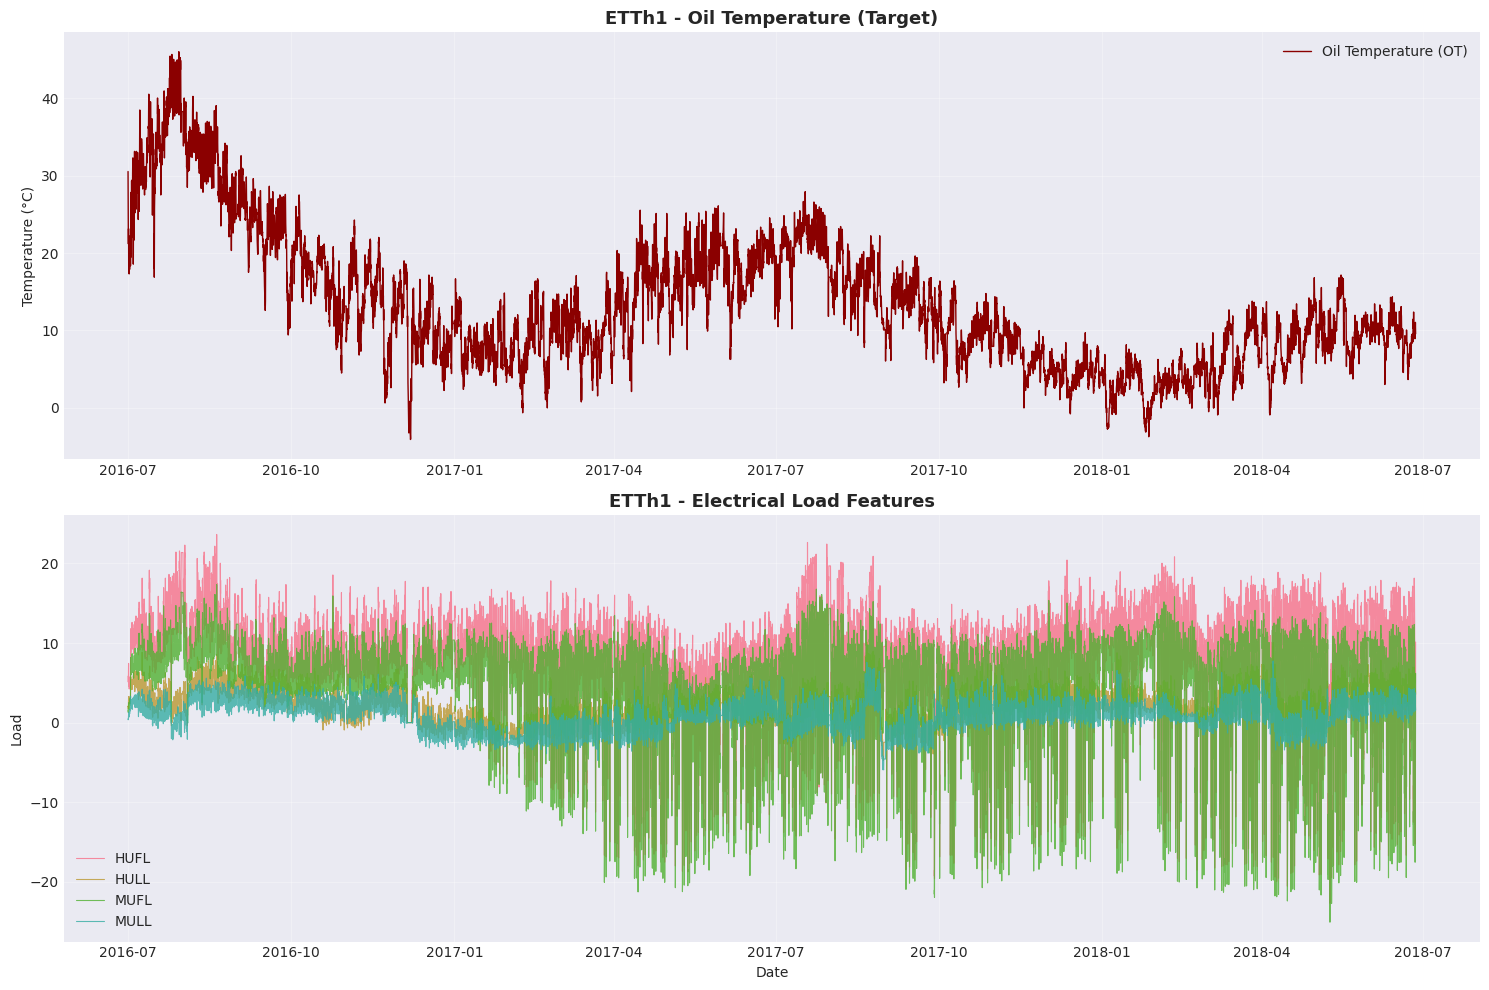

In [3]:
# Visualize the target series and load features
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot target: Oil Temperature
axes[0].plot(target_series.index, target_series.values, label='Oil Temperature (OT)', color='darkred', linewidth=1)
axes[0].set_title('ETTh1 - Oil Temperature (Target)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Temperature (°C)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot load features
for col in load_columns:
    axes[1].plot(load_features.index, load_features[col].values, label=col, linewidth=0.8, alpha=0.8)
axes[1].set_title('ETTh1 - Electrical Load Features', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Load')
axes[1].set_xlabel('Date')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Preprocessing with STL Decomposition + Multivariate Features

**Advanced Multivariate Preprocessing Strategy:**
1. **STL Decomposition** - Applied to OT (target) to extract residuals
2. **Feature Engineering** - Include electrical load features (HUFL, HULL, MUFL, MULL)
3. **Hybrid Normalization** - MinMax scaling for both residuals and load features
4. **Sequence Creation** - Sliding window with multivariate input, univariate output

**Configuration:**
- **Target**: OT Residuals (after STL decomposition)
- **Features**: OT Residuals + 4 Load Features = **5 input features**
- **Lookback:** 96 hours (4 days)
- **Horizon:** 24 hours (1 day)
- **Key Insight**: Load features provide causal information for residual prediction

Step 1: STL Decomposition on Oil Temperature (OT)...


STL Decomposition completed:
  Trend shape: (17420,)
  Seasonal shape: (17420,)
  Residual shape: (17420,)


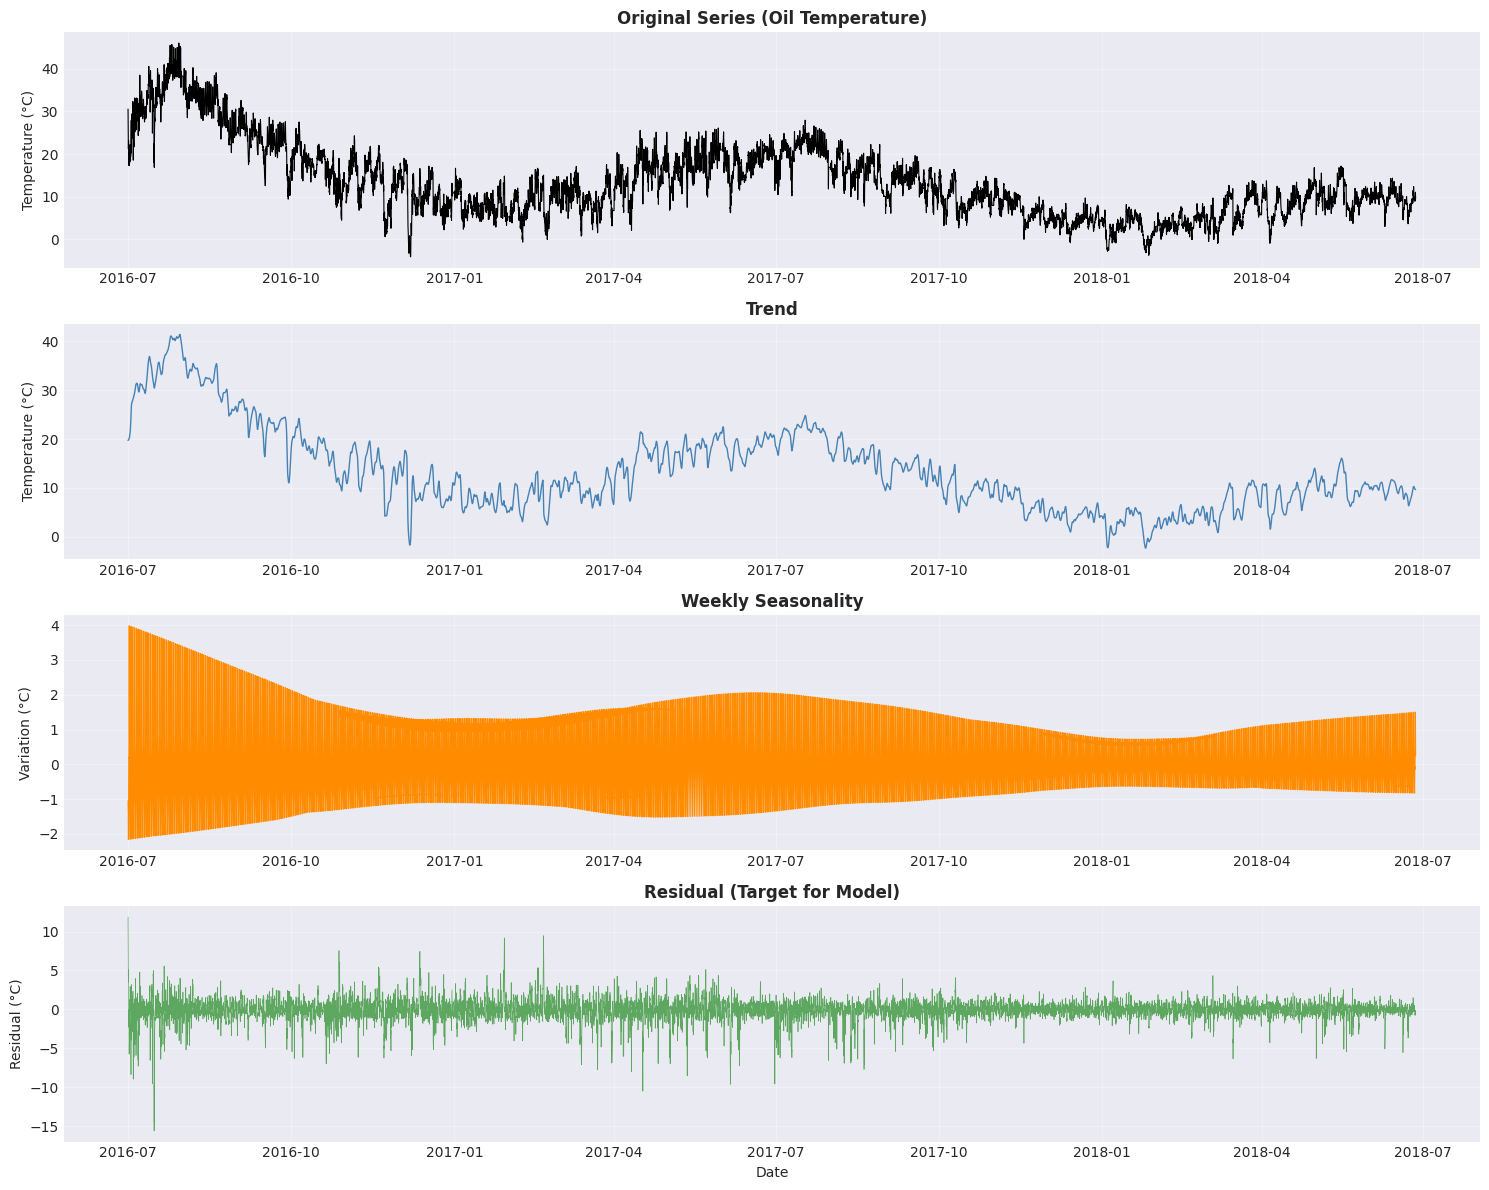

STL decomposition visualized

Step 2: Data Cleaning and Alignment...
Clean residual shape: (17420,)
Aligned load features shape: (17420, 4)

Step 3: Normalization (Hybrid Strategy)...
  Target (OT Residuals): MinMaxScaler [0, 1]
  Features (Loads): MinMaxScaler [0, 1] per column

Target (Residual) normalization:
  Original range: [-15.5826, 11.8515]
  Normalized range: [-11.8522, 9.1263]
  Mean: -0.0000, Std: 1.0000

Features (Loads) normalization:
  Shape: (17420, 4)
  HUFL: [-22.71, 23.64] -> [0.0000, 1.0000]
  HULL: [-4.76, 10.11] -> [0.0000, 1.0000]
  MUFL: [-25.09, 17.34] -> [0.0000, 1.0000]
  MULL: [-5.93, 7.75] -> [0.0000, 1.0000]

Step 4: Creating Multivariate Input...
Multivariate input created:
  Shape: (17420, 5)
  Features: ['OT_Residual', 'HUFL', 'HULL', 'MUFL', 'MULL']
  Feature 0 (OT_Residual) range: [-11.8522, 9.1263]
  Feature 1 (HUFL) range: [0.0000, 1.0000]

Components stored for reconstruction:
  Residual (normalized): (17420,)
  Trend (aligned): (17420,)
  Seasonal

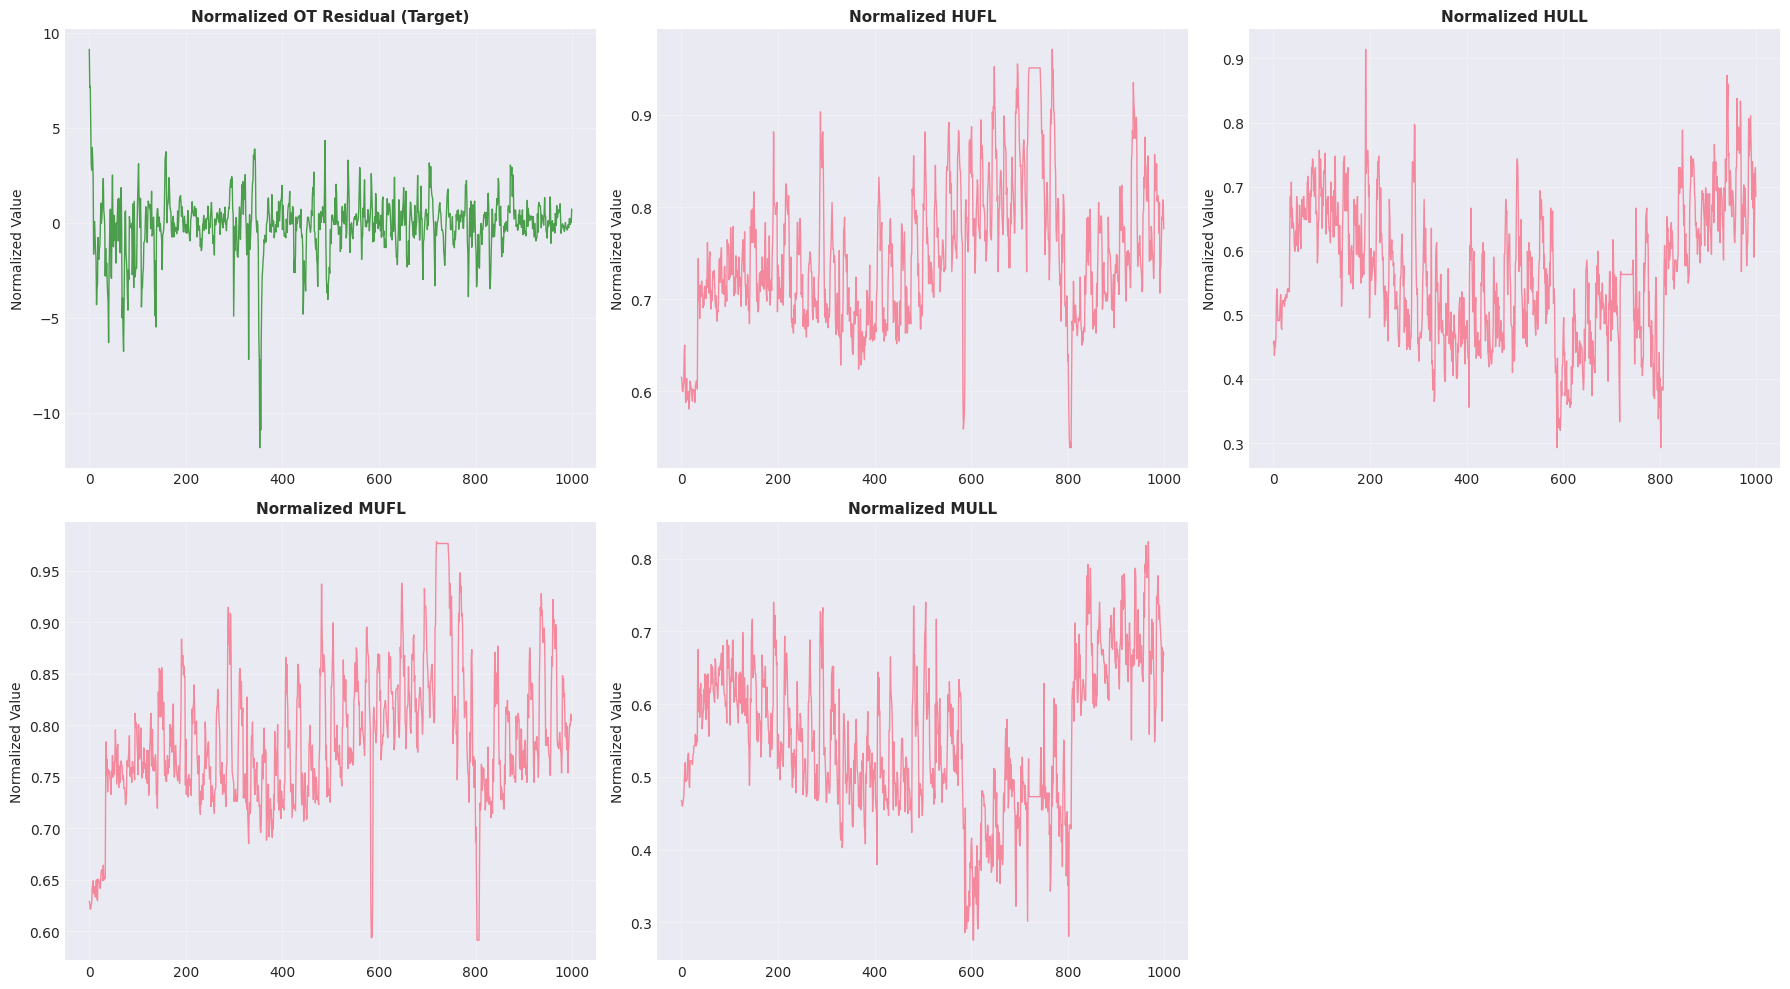


Step 5: Creating Multivariate Sequences (Sliding Window)...
Sequences created:
  X shape: (17301, 96, 5) (n_samples, lookback, n_features)
  y shape: (17301, 24) (n_samples, horizon)
  Total samples: 17301
  Input features per timestep: 5

Step 6: Train/Validation/Test Split...
Split completed:
  Train: X=(12110, 96, 5), y=(12110, 24)
  Val:   X=(2595, 96, 5), y=(2595, 24)
  Test:  X=(2596, 96, 5), y=(2596, 24)

Test set reconstruction info:
  Test predictions start at index: 14801

PyTorch tensors created and moved to cuda
  X_train_tensor: torch.Size([12110, 96, 5])
  y_train_tensor: torch.Size([12110, 24, 1])

PREPROCESSING COMPLETE - MULTIVARIATE RESIDUAL LEARNING ENABLED
Models will learn residuals using electrical load context!


In [4]:
# Step 1: STL Decomposition on TARGET (OT) ONLY
print("Step 1: STL Decomposition on Oil Temperature (OT)...")
print("="*60)
# Seasonal period: 24 hours (1 day) + 168 hours (1 week)
# Using 169 = 7*24 + 1 for weekly seasonality
stl = STL(target_series, seasonal=169, robust=True)
result = stl.fit()

trend = result.trend
seasonal = result.seasonal
residual = result.resid

print(f"STL Decomposition completed:")
print(f"  Trend shape: {trend.shape}")
print(f"  Seasonal shape: {seasonal.shape}")
print(f"  Residual shape: {residual.shape}")

# STL decomposition visualization
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

axes[0].plot(target_series.index, target_series.values, linewidth=0.8, color='black')
axes[0].set_title('Original Series (Oil Temperature)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Temperature (°C)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(trend.index, trend.values, linewidth=1, color='steelblue')
axes[1].set_title('Trend', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Temperature (°C)')
axes[1].grid(True, alpha=0.3)

axes[2].plot(seasonal.index, seasonal.values, linewidth=0.8, color='darkorange')
axes[2].set_title('Weekly Seasonality', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Variation (°C)')
axes[2].grid(True, alpha=0.3)

axes[3].plot(residual.index, residual.values, linewidth=0.5, color='forestgreen', alpha=0.7)
axes[3].set_title('Residual (Target for Model)', fontsize=12, fontweight='bold')
axes[3].set_ylabel('Residual (°C)')
axes[3].set_xlabel('Date')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("STL decomposition visualized")

# Step 2: Clean and align data
print("\nStep 2: Data Cleaning and Alignment...")
# Drop NaN values from residuals
residual_clean = residual.dropna()

# Align load features with clean residuals
load_features_aligned = load_features.loc[residual_clean.index]

print(f"Clean residual shape: {residual_clean.shape}")
print(f"Aligned load features shape: {load_features_aligned.shape}")

# Step 3: Normalization - HYBRID STRATEGY
print("\nStep 3: Normalization (Hybrid Strategy)...")
print("  Target (OT Residuals): MinMaxScaler [0, 1]")
print("  Features (Loads): MinMaxScaler [0, 1] per column")

# Normalize TARGET (residuals)
# scaler_target = MinMaxScaler(feature_range=(0, 1))
scaler_target = StandardScaler()
residual_normalized = scaler_target.fit_transform(residual_clean.values.reshape(-1, 1))
residual_normalized = residual_normalized.flatten()

print(f"\nTarget (Residual) normalization:")
print(f"  Original range: [{residual_clean.min():.4f}, {residual_clean.max():.4f}]")
print(f"  Normalized range: [{residual_normalized.min():.4f}, {residual_normalized.max():.4f}]")
print(f"  Mean: {residual_normalized.mean():.4f}, Std: {residual_normalized.std():.4f}")

# Normalize FEATURES (loads) - Each column independently
scaler_features = MinMaxScaler(feature_range=(0, 1))
load_normalized = scaler_features.fit_transform(load_features_aligned.values)

print(f"\nFeatures (Loads) normalization:")
print(f"  Shape: {load_normalized.shape}")
for i, col in enumerate(load_columns):
    print(f"  {col}: [{load_features_aligned[col].min():.2f}, {load_features_aligned[col].max():.2f}] -> [{load_normalized[:, i].min():.4f}, {load_normalized[:, i].max():.4f}]")

# Step 4: Create MULTIVARIATE input by combining residual + loads
print("\nStep 4: Creating Multivariate Input...")
# Input features: [Normalized_OT_Residual, Norm_HUFL, Norm_HULL, Norm_MUFL, Norm_MULL]
# Shape: (num_samples, 5)

# Combine: residual as first column, then load features
multivariate_input = np.column_stack([residual_normalized, load_normalized])

print(f"Multivariate input created:")
print(f"  Shape: {multivariate_input.shape}")
print(f"  Features: ['OT_Residual', 'HUFL', 'HULL', 'MUFL', 'MULL']")
print(f"  Feature 0 (OT_Residual) range: [{multivariate_input[:, 0].min():.4f}, {multivariate_input[:, 0].max():.4f}]")
print(f"  Feature 1 (HUFL) range: [{multivariate_input[:, 1].min():.4f}, {multivariate_input[:, 1].max():.4f}]")

# Save ALL components for reconstruction (aligned with residual_clean)
trend_aligned = trend.loc[residual_clean.index].values
seasonal_aligned = seasonal.loc[residual_clean.index].values

print(f"\nComponents stored for reconstruction:")
print(f"  Residual (normalized): {residual_normalized.shape}")
print(f"  Trend (aligned): {trend_aligned.shape}")
print(f"  Seasonal (aligned): {seasonal_aligned.shape}")

# Store reconstruction info
reconstruction_info = {
    'scaler_target': scaler_target,
    'scaler_features': scaler_features,
    'trend': trend_aligned,
    'seasonal': seasonal_aligned,
    'residual_index': residual_clean.index,
    'load_columns': load_columns
}

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Plot normalized target
axes[0].plot(residual_normalized[:1000], linewidth=1, color='forestgreen', alpha=0.8)
axes[0].set_title('Normalized OT Residual (Target)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Normalized Value')
axes[0].grid(True, alpha=0.3)

# Plot normalized load features
for i, col in enumerate(load_columns):
    axes[i+1].plot(load_normalized[:1000, i], linewidth=1, alpha=0.8)
    axes[i+1].set_title(f'Normalized {col}', fontsize=11, fontweight='bold')
    axes[i+1].set_ylabel('Normalized Value')
    axes[i+1].grid(True, alpha=0.3)

# Remove empty subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

# Step 5: Sequence creation using Sliding Window - MULTIVARIATE
print("\nStep 5: Creating Multivariate Sequences (Sliding Window)...")

# Hyperparameters
LOOKBACK = 96   # 96 hours (4 days) of context for prediction
HORIZON = 24    # 24 hours (1 day) of future prediction

def create_sequences_multivariate(input_data, target_data, lookback, horizon):
    """
    Creates multivariate input (X) and univariate output (y) sequences.
    
    Args:
        input_data: 2D array (num_timesteps, num_features) - All features including target residual
        target_data: 1D array (num_timesteps,) - Only the target residual
        lookback: number of past timesteps as input
        horizon: number of future timesteps to predict
    
    Returns:
        X: array (n_samples, lookback, num_features)
        y: array (n_samples, horizon, 1)
    """
    X, y = [], []
    for i in range(len(input_data) - lookback - horizon + 1):
        # Input: all features (residual + loads) for lookback window
        X.append(input_data[i:i+lookback])
        # Output: only target residual for forecast horizon
        y.append(target_data[i+lookback:i+lookback+horizon])
    return np.array(X), np.array(y)

X, y = create_sequences_multivariate(multivariate_input, residual_normalized, LOOKBACK, HORIZON)

print(f"Sequences created:")
print(f"  X shape: {X.shape} (n_samples, lookback, n_features)")
print(f"  y shape: {y.shape} (n_samples, horizon)")
print(f"  Total samples: {len(X)}")
print(f"  Input features per timestep: {X.shape[2]}")

# Step 6: Train/Validation/Test Split
print("\nStep 6: Train/Validation/Test Split...")

# Split: 70% train, 15% validation, 15% test
train_size = int(0.70 * len(X))
val_size = int(0.15 * len(X))

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

print(f"Split completed:")
print(f"  Train: X={X_train.shape}, y={y_train.shape}")
print(f"  Val:   X={X_val.shape}, y={y_val.shape}")
print(f"  Test:  X={X_test.shape}, y={y_test.shape}")

# Store indices for reconstruction
test_start_idx = train_size + val_size + LOOKBACK

print(f"\nTest set reconstruction info:")
print(f"  Test predictions start at index: {test_start_idx}")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)  # (batch, seq, features)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(-1).to(device)  # (batch, seq, 1)

X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val).unsqueeze(-1).to(device)

X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(-1).to(device)

print(f"\nPyTorch tensors created and moved to {device}")
print(f"  X_train_tensor: {X_train_tensor.shape}")
print(f"  y_train_tensor: {y_train_tensor.shape}")

print("\n" + "="*60)
print("PREPROCESSING COMPLETE - MULTIVARIATE RESIDUAL LEARNING ENABLED")
print("Models will learn residuals using electrical load context!")
print("="*60)

## 4. Models

I'll reuse the architectures defined previously (short_term.ipynb).

1. **LSTM Seq2Seq**
2. **Transformer (MHA)**
3. **Transformer (Fourier)**
4. **Transformer (ProbSparse)**



In [5]:
class LSTMSeq2Seq(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, output_size=1, dropout=0.1):
        super(LSTMSeq2Seq, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.decoder = nn.LSTM(output_size, hidden_size * 2, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        
    def forward(self, src, trg=None, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        trg_len = trg.size(1) if trg is not None else 24 # Default to HORIZON
        
        _, (hidden, cell) = self.encoder(src)
        
        # Reshape for decoder
        hidden = hidden.view(self.num_layers, 2, batch_size, self.hidden_size)
        hidden = torch.cat((hidden[:, 0, :, :], hidden[:, 1, :, :]), dim=2)
        cell = cell.view(self.num_layers, 2, batch_size, self.hidden_size)
        cell = torch.cat((cell[:, 0, :, :], cell[:, 1, :, :]), dim=2)
        
        # Only take the target feature (index 0) for decoder input
        decoder_input = src[:, -1, 0:1].unsqueeze(1)
        outputs = []
        
        for t in range(trg_len):
            decoder_output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            prediction = self.fc(decoder_output)
            outputs.append(prediction)
            
            if trg is not None and np.random.random() < teacher_forcing_ratio:
                decoder_input = trg[:, t, :].unsqueeze(1)
            else:
                decoder_input = prediction
        
        return torch.cat(outputs, dim=1)

model_lstm = LSTMSeq2Seq(input_size=5, output_size=1).to(device)
print("LSTM Model Created (Input: 5 features, Output: 1)")

LSTM Model Created (Input: 5 features, Output: 1)


In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class TransformerSeq2Seq(nn.Module):
    def __init__(self, input_size=1, d_model=128, nhead=8, num_layers=3, dim_feedforward=512, dropout=0.1, output_size=1):
        super(TransformerSeq2Seq, self).__init__()
        self.d_model = d_model
        self.input_embedding = nn.Linear(input_size, d_model)
        self.output_embedding = nn.Linear(output_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_layers, 
                                          num_decoder_layers=num_layers, dim_feedforward=dim_feedforward, 
                                          dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(d_model, output_size)
        
    def forward(self, src, trg=None, trg_len=24):
        src_original = src  # Store original before embedding
        src = self.pos_encoder(self.input_embedding(src) * np.sqrt(self.d_model))
        
        if trg is not None:
            # Training: use teacher forcing
            # Only take the target feature (index 0) for decoder start
            decoder_start = self.output_embedding(src_original[:, -1:, 0:1]) * np.sqrt(self.d_model)
            decoder_trg = self.output_embedding(trg[:, :-1, :]) * np.sqrt(self.d_model)
            decoder_input = torch.cat([decoder_start, decoder_trg], dim=1)
            decoder_input = self.pos_encoder(decoder_input)
            trg_mask = self.transformer.generate_square_subsequent_mask(trg.size(1)).to(src.device)
            output = self.transformer(src, decoder_input, tgt_mask=trg_mask)
        else:
            # Inference: autoregressive generation starting from last input
            # Only take the target feature (index 0)
            decoder_input = src_original[:, -1:, 0:1]
            outputs = []
            for i in range(trg_len):
                decoder_embedded = self.pos_encoder(self.output_embedding(decoder_input) * np.sqrt(self.d_model))
                trg_mask = self.transformer.generate_square_subsequent_mask(decoder_input.size(1)).to(src.device)
                output = self.transformer(src, decoder_embedded, tgt_mask=trg_mask)
                prediction = self.fc_out(output[:, -1:, :])
                outputs.append(prediction)
                decoder_input = torch.cat([decoder_input, prediction], dim=1)
            return torch.cat(outputs, dim=1)
            
        return self.fc_out(output)


model_transformer = TransformerSeq2Seq(input_size=5, output_size=1).to(device)
print("Transformer Model Created (Input: 5 features, Output: 1)")

Transformer Model Created (Input: 5 features, Output: 1)


In [7]:
class FourierLayer(nn.Module):
    def __init__(self, d_model):
        super(FourierLayer, self).__init__()
        self.d_model = d_model
    def forward(self, x):
        x_fft = torch.fft.rfft(x, dim=1, norm='ortho')
        x_real = torch.real(x_fft)
        if x_real.size(1) < x.size(1):
            padding = torch.zeros(x.size(0), x.size(1) - x_real.size(1), x.size(2)).to(x.device)
            x_real = torch.cat([x_real, padding], dim=1)
        return x_real[:, :x.size(1), :]

class TransformerFourier(nn.Module):
    def __init__(self, input_size=1, d_model=128, nhead=8, num_layers=3, dim_feedforward=512, dropout=0.1, output_size=1):
        super(TransformerFourier, self).__init__()
        self.d_model = d_model
        self.input_embedding = nn.Linear(input_size, d_model // 2)
        self.output_embedding = nn.Linear(output_size, d_model)
        self.fourier_layer = FourierLayer(d_model // 2)
        self.projection = nn.Linear(d_model, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_layers, 
                                          num_decoder_layers=num_layers, dim_feedforward=dim_feedforward, 
                                          dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(d_model, output_size)
        
    def forward(self, src, trg=None, trg_len=24):
        src_original = src  # Store before embedding
        src_emb = self.input_embedding(src)
        src_four = self.fourier_layer(src_emb)
        src_combined = self.pos_encoder(self.projection(torch.cat([src_emb, src_four], dim=-1)) * np.sqrt(self.d_model))
        
        if trg is not None:
            # Training: use teacher forcing
            # Only take the target feature (index 0) for decoder start
            decoder_start = self.output_embedding(src_original[:, -1:, 0:1]) * np.sqrt(self.d_model)
            decoder_trg = self.output_embedding(trg[:, :-1, :]) * np.sqrt(self.d_model)
            decoder_input = torch.cat([decoder_start, decoder_trg], dim=1)
            decoder_input = self.pos_encoder(decoder_input)
            trg_mask = self.transformer.generate_square_subsequent_mask(trg.size(1)).to(src.device)
            output = self.transformer(src_combined, decoder_input, tgt_mask=trg_mask)
        else:
            # Inference: autoregressive generation starting from last input
            # Only take the target feature (index 0)
            decoder_input = src_original[:, -1:, 0:1]
            outputs = []
            for i in range(trg_len):
                decoder_embedded = self.pos_encoder(self.output_embedding(decoder_input) * np.sqrt(self.d_model))
                trg_mask = self.transformer.generate_square_subsequent_mask(decoder_input.size(1)).to(src.device)
                output = self.transformer(src_combined, decoder_embedded, tgt_mask=trg_mask)
                prediction = self.fc_out(output[:, -1:, :])
                outputs.append(prediction)
                decoder_input = torch.cat([decoder_input, prediction], dim=1)
            return torch.cat(outputs, dim=1)
            
        return self.fc_out(output)

model_fourier = TransformerFourier(input_size=5, output_size=1).to(device)
print("Fourier Transformer Created (Input: 5 features, Output: 1)")

Fourier Transformer Created (Input: 5 features, Output: 1)


In [8]:
class ProbSparseAttention(nn.Module):
    def __init__(self, d_model, nhead, factor=5):
        super(ProbSparseAttention, self).__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.d_k = d_model // nhead
        self.factor = factor
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_linear = nn.Linear(d_model, d_model)
        
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()
        Q = self.q_linear(x).view(batch_size, seq_len, self.nhead, self.d_k).transpose(1, 2)
        K = self.k_linear(x).view(batch_size, seq_len, self.nhead, self.d_k).transpose(1, 2)
        V = self.v_linear(x).view(batch_size, seq_len, self.nhead, self.d_k).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        M = scores.max(dim=-1)[0] - scores.mean(dim=-1)
        k = max(1, seq_len // self.factor)
        top_queries = torch.topk(M, k, dim=-1)[1]
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attn = F.softmax(scores, dim=-1)
        out = torch.matmul(attn, V)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        return self.out_linear(out)

class TransformerProbSparse(nn.Module):
    def __init__(self, input_size=1, d_model=128, nhead=8, num_layers=3, dim_feedforward=512, dropout=0.1, output_size=1):
        super(TransformerProbSparse, self).__init__()
        self.d_model = d_model
        self.input_embedding = nn.Linear(input_size, d_model)
        self.output_embedding = nn.Linear(output_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        
        self.encoder_layers = nn.ModuleList([
            nn.ModuleDict({
                'attention': ProbSparseAttention(d_model, nhead),
                'norm1': nn.LayerNorm(d_model),
                'ff': nn.Sequential(nn.Linear(d_model, dim_feedforward), nn.ReLU(), nn.Dropout(dropout), nn.Linear(dim_feedforward, d_model)),
                'norm2': nn.LayerNorm(d_model),
                'dropout': nn.Dropout(dropout)
            }) for _ in range(num_layers)
        ])
        
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        self.fc_out = nn.Linear(d_model, output_size)
        
    def forward(self, src, trg=None, trg_len=24):
        src_original = src  # Store before embedding
        src = self.pos_encoder(self.input_embedding(src) * np.sqrt(self.d_model))
        for layer in self.encoder_layers:
            src = layer['norm1'](src + layer['dropout'](layer['attention'](src)))
            src = layer['norm2'](src + layer['dropout'](layer['ff'](src)))
        
        memory = src
        if trg is not None:
            # Training: use teacher forcing
            # Only take the target feature (index 0) for decoder start
            decoder_start = self.output_embedding(src_original[:, -1:, 0:1]) * np.sqrt(self.d_model)
            decoder_trg = self.output_embedding(trg[:, :-1, :]) * np.sqrt(self.d_model)
            decoder_input = torch.cat([decoder_start, decoder_trg], dim=1)
            decoder_input = self.pos_encoder(decoder_input)
            trg_mask = nn.Transformer.generate_square_subsequent_mask(trg.size(1)).to(src.device)
            output = self.decoder(decoder_input, memory, tgt_mask=trg_mask)
        else:
            # Inference: autoregressive generation starting from last input
            # Only take the target feature (index 0)
            decoder_input = src_original[:, -1:, 0:1]
            outputs = []
            for i in range(trg_len):
                decoder_embedded = self.pos_encoder(self.output_embedding(decoder_input) * np.sqrt(self.d_model))
                trg_mask = nn.Transformer.generate_square_subsequent_mask(decoder_input.size(1)).to(src.device)
                output = self.decoder(decoder_embedded, memory, tgt_mask=trg_mask)
                prediction = self.fc_out(output[:, -1:, :])
                outputs.append(prediction)
                decoder_input = torch.cat([decoder_input, prediction], dim=1)
            return torch.cat(outputs, dim=1)
        return self.fc_out(output)

model_probsparse = TransformerProbSparse(input_size=5, output_size=1).to(device)
print("ProbSparse Model Created (Input: 5 features, Output: 1)")

ProbSparse Model Created (Input: 5 features, Output: 1)


## 5. Training and Evaluation


In [9]:
from tqdm import tqdm

class CombinedLoss(nn.Module):
    """
    Loss focused on capturing LOCAL DYNAMICS (not just global trends)
    1. MSE (base accuracy)
    2. First-order differences (capture slope changes)
    3. Second-order differences (capture curvature)
    """
    def __init__(self, mse_weight=0.3, diff1_weight=0.5, diff2_weight=0.2):
        super(CombinedLoss, self).__init__()
        self.mse_weight = mse_weight
        self.diff1_weight = diff1_weight
        self.diff2_weight = diff2_weight
        
    def forward(self, pred, target):
        # Base MSE
        mse = F.mse_loss(pred, target)
        
        # First-order differences (slope matching)
        pred_diff1 = pred[:, 1:, :] - pred[:, :-1, :]
        target_diff1 = target[:, 1:, :] - target[:, :-1, :]
        diff1_loss = F.mse_loss(pred_diff1, target_diff1)
        
        # Second-order differences (acceleration/curvature matching)
        pred_diff2 = pred_diff1[:, 1:, :] - pred_diff1[:, :-1, :]
        target_diff2 = target_diff1[:, 1:, :] - target_diff1[:, :-1, :]
        diff2_loss = F.mse_loss(pred_diff2, target_diff2)
        
        return self.mse_weight * mse + self.diff1_weight * diff1_loss + self.diff2_weight * diff2_loss

def train_model(model, X_train, y_train, X_val, y_val, name, epochs=50, batch_size=64):
    print(f"\nTraining {name}...")
    
    # Dynamics-focused loss (heavily weights derivatives)
    # criterion = CombinedLoss(mse_weight=0.3, diff1_weight=0.5, diff2_weight=0.2)
    criterion = nn.MSELoss()
    
    # Moderate learning rate
    lr = 0.001
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    
    # Learning rate scheduler with warmup
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=lr * 5,
        epochs=epochs,
        steps_per_epoch=len(X_train) // batch_size + 1,
        pct_start=0.1,
        anneal_strategy='cos'
    )
    
    train_loader = DataLoader(
        torch.utils.data.TensorDataset(X_train, y_train), 
        batch_size=batch_size, 
        shuffle=True
    )
    
    train_losses, val_losses = [], []
    best_val = float('inf')
    patience_counter = 0
    patience = 15  # Increased patience
    
    for epoch in range(epochs):
        model.train()
        t_loss = 0
        for bx, by in train_loader:
            optimizer.zero_grad()
            
            if isinstance(model, LSTMSeq2Seq):
                pred = model(bx, by, teacher_forcing_ratio=0.5)
            else:
                pred = model(bx, by)
            
            loss = criterion(pred, by)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            t_loss += loss.item()
        
        t_loss /= len(train_loader)
        train_losses.append(t_loss)
        
        # Validation
        model.eval()
        with torch.no_grad():
            if isinstance(model, LSTMSeq2Seq):
                v_pred = model(X_val, y_val, teacher_forcing_ratio=0)
            else:
                v_pred = model(X_val, y_val)
            v_loss = criterion(v_pred, y_val).item()
            val_losses.append(v_loss)
        
        # Save best model
        if v_loss < best_val:
            best_val = v_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'best_{name.replace(" ", "_")}.pth')
        else:
            patience_counter += 1
            
        if (epoch+1) % 10 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Epoch {epoch+1}/{epochs}: Train {t_loss:.5f}, Val {v_loss:.5f}, LR {current_lr:.6f}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(torch.load(f'best_{name.replace(" ", "_")}.pth'))
    print(f"Best validation loss: {best_val:.5f}")
    
    return train_losses, val_losses

def evaluate(model, X_test, y_test, reconstruct=True):
    """
    Evaluate model and optionally reconstruct full signal.
    
    Args:
        model: The trained model
        X_test: Test input (normalized residuals)
        y_test: Test output (normalized residuals)
        reconstruct: If True, reconstruct full signal by adding trend + seasonal
    
    Returns:
        mse, mae, corr, predictions (reconstructed if reconstruct=True)
    """
    model.eval()
    with torch.no_grad():
        if isinstance(model, LSTMSeq2Seq):
            pred_residuals = model(X_test, None)
        else:
            pred_residuals = model(X_test, None, trg_len=24)
    
    # Convert to numpy
    pred_residuals_np = pred_residuals.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    
    if reconstruct:
        # RECONSTRUCTION: Add back trend and seasonal components
        print("Reconstructing full signal from residuals...")
        
        # Get the reconstruction components
        trend_full = reconstruction_info['trend']
        seasonal_full = reconstruction_info['seasonal']
        scaler = reconstruction_info['scaler_target']  # Use target scaler
        
        # For each test sample, we need to get the corresponding trend+seasonal
        # Test sequences start at index: train_size + val_size + LOOKBACK
        test_start = train_size + val_size + LOOKBACK
        
        # Initialize reconstructed predictions and ground truth
        pred_reconstructed = np.zeros_like(pred_residuals_np)
        y_reconstructed = np.zeros_like(y_test_np)
        
        for i in range(len(pred_residuals_np)):
            # Current sample predicts from time test_start+i to test_start+i+HORIZON
            start_idx = test_start + i
            end_idx = start_idx + HORIZON
            
            # Inverse transform residuals (denormalize)
            pred_resid_denorm = scaler.inverse_transform(pred_residuals_np[i])
            y_resid_denorm = scaler.inverse_transform(y_test_np[i])
            
            # Add trend and seasonal components
            trend_component = trend_full[start_idx:end_idx].reshape(-1, 1)
            seasonal_component = seasonal_full[start_idx:end_idx].reshape(-1, 1)
            
            # Final reconstruction: residual + trend + seasonal
            pred_reconstructed[i] = pred_resid_denorm + trend_component + seasonal_component
            y_reconstructed[i] = y_resid_denorm + trend_component + seasonal_component
        
        # Calculate metrics on RECONSTRUCTED (original scale) data
        mse = mean_squared_error(y_reconstructed.flatten(), pred_reconstructed.flatten())
        mae = mean_absolute_error(y_reconstructed.flatten(), pred_reconstructed.flatten())
        
        # Correlation
        from scipy.stats import pearsonr
        corr, _ = pearsonr(y_reconstructed.flatten(), pred_reconstructed.flatten())
        
        print(f"  Reconstruction complete. Metrics on original scale.")
        
        return mse, mae, corr, pred_reconstructed, y_reconstructed
    else:
        # Calculate metrics on normalized residuals only
        mse = mean_squared_error(y_test_np.flatten(), pred_residuals_np.flatten())
        mae = mean_absolute_error(y_test_np.flatten(), pred_residuals_np.flatten())
        
        from scipy.stats import pearsonr
        corr, _ = pearsonr(y_test_np.flatten(), pred_residuals_np.flatten())
        
        return mse, mae, corr, pred_residuals_np, y_test_np


In [10]:
results = {}
models = [
    (model_lstm, "LSTM"),
    (model_transformer, "Transformer"),
    (model_fourier, "Fourier"),
    (model_probsparse, "ProbSparse")
]

print("TRAINING ALL MODELS WITH RESIDUAL-ONLY LEARNING")

for model, name in models:
    tl, vl = train_model(
        model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, 
        name, epochs=50, batch_size=64
    )
    mse, mae, corr, preds, y_true = evaluate(model, X_test_tensor, y_test_tensor, reconstruct=True)
    results[name] = {'mse': mse, 'mae': mae, 'corr': corr, 'preds': preds, 'y_true': y_true, 'tl': tl, 'vl': vl}
    print(f"\n{name} - Final Test Metrics (Reconstructed - Original Scale):")
    print(f"  MSE:         {mse:.5f}")
    print(f"  MAE:         {mae:.5f}")
    print(f"  Correlation: {corr:.4f}")
    print(f"  MAE:         {mae:.5f}")
    print(f"  Correlation: {corr:.4f}")

print("ALL MODELS TRAINED!")


TRAINING ALL MODELS WITH RESIDUAL-ONLY LEARNING

Training LSTM...
Epoch 10/50: Train 0.61792, Val 0.30750, LR 0.004849
Epoch 10/50: Train 0.61792, Val 0.30750, LR 0.004849
Epoch 20/50: Train 0.55478, Val 0.34494, LR 0.003749
Epoch 20/50: Train 0.55478, Val 0.34494, LR 0.003749
Early stopping at epoch 25
Best validation loss: 0.30750
Reconstructing full signal from residuals...
Early stopping at epoch 25
Best validation loss: 0.30750
Reconstructing full signal from residuals...
  Reconstruction complete. Metrics on original scale.

LSTM - Final Test Metrics (Reconstructed - Original Scale):
  MSE:         0.73637
  MAE:         0.55738
  Correlation: 0.9547
  MAE:         0.55738
  Correlation: 0.9547

Training Transformer...
  Reconstruction complete. Metrics on original scale.

LSTM - Final Test Metrics (Reconstructed - Original Scale):
  MSE:         0.73637
  MAE:         0.55738
  Correlation: 0.9547
  MAE:         0.55738
  Correlation: 0.9547

Training Transformer...
Epoch 10/50:

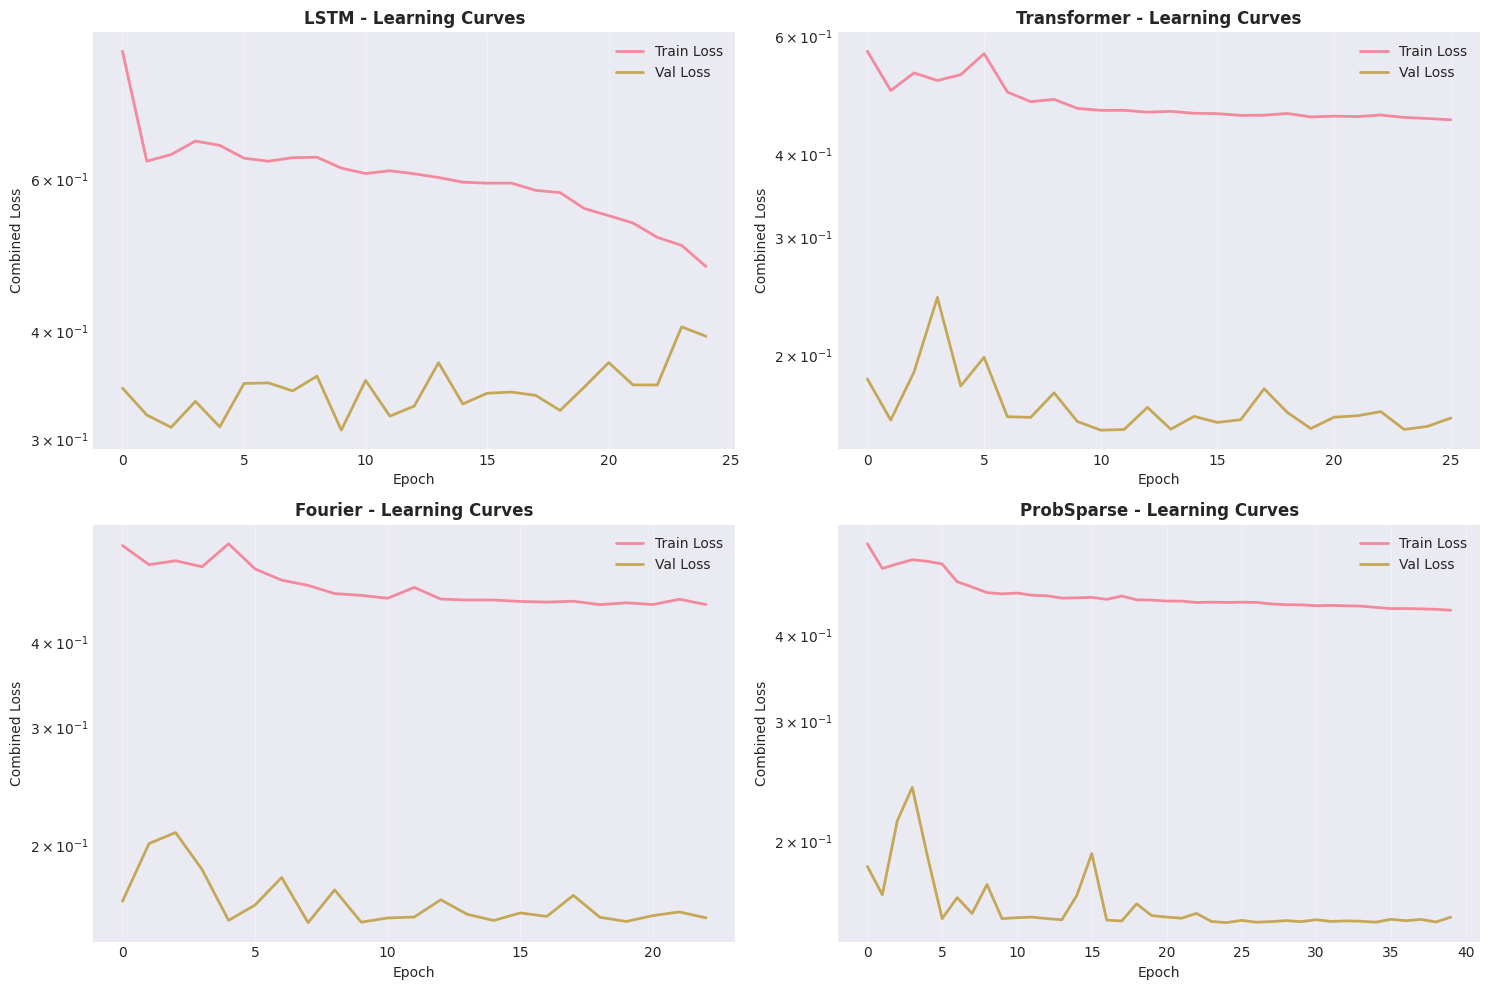

METRICS COMPARISON
                  MSE       MAE  Correlation
LSTM         0.736366  0.557382     0.954709
Transformer  0.762223  0.570780     0.952373
Fourier      0.762553  0.569125     0.952595
ProbSparse   0.775426  0.575505     0.952540
Improvement relative to LSTM Baseline:
                  MSE  Correlation  MSE Improvement vs LSTM (%)
LSTM         0.736366     0.954709                         0.00
Transformer  0.762223     0.952373                        -3.51
Fourier      0.762553     0.952595                        -3.56
ProbSparse   0.775426     0.952540                        -5.30


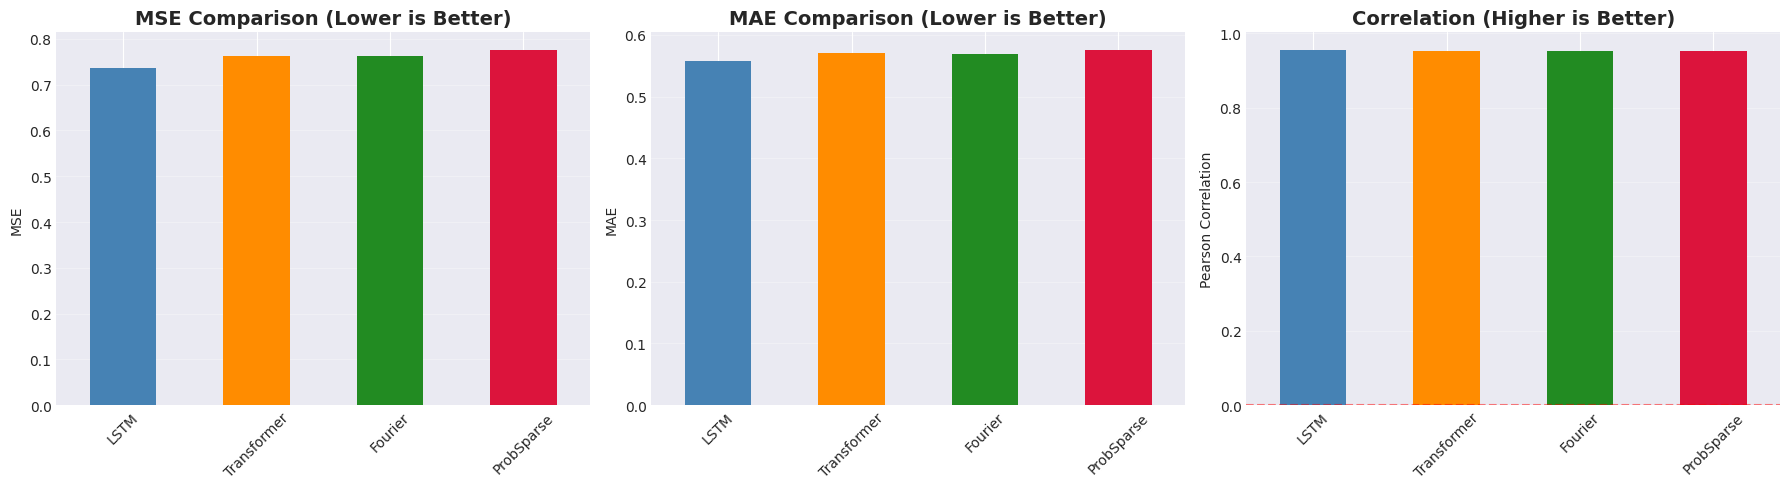

In [11]:
# Training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, (name, res) in enumerate(results.items()):
    axes[idx].plot(res['tl'], label='Train Loss', linewidth=2, alpha=0.8)
    axes[idx].plot(res['vl'], label='Val Loss', linewidth=2, alpha=0.8)
    axes[idx].set_title(f'{name} - Learning Curves', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel('Combined Loss')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_yscale('log')

plt.tight_layout()
plt.show()

# Metrics comparison
print("METRICS COMPARISON")

metrics = pd.DataFrame({
    name: {
        'MSE': res['mse'], 
        'MAE': res['mae'], 
        'Correlation': res['corr']
    } for name, res in results.items()
}).T

metrics_sorted = metrics.sort_values('MSE')
print(metrics_sorted)

# Calculate improvement over LSTM
lstm_mse = metrics.loc['LSTM', 'MSE']
metrics_sorted['MSE Improvement vs LSTM (%)'] = ((lstm_mse - metrics_sorted['MSE']) / lstm_mse * 100).round(2)

print("Improvement relative to LSTM Baseline:")
print(metrics_sorted[['MSE', 'Correlation', 'MSE Improvement vs LSTM (%)']].to_string())

# Bar plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['steelblue', 'darkorange', 'forestgreen', 'crimson']

# MSE comparison
metrics_sorted['MSE'].plot(kind='bar', ax=axes[0], color=colors[:len(metrics_sorted)])
axes[0].set_title('MSE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MSE')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

# MAE comparison  
metrics_sorted['MAE'].plot(kind='bar', ax=axes[1], color=colors[:len(metrics_sorted)])
axes[1].set_title('MAE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MAE')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

# Correlation (Higher is Better)
metrics_sorted['Correlation'].plot(kind='bar', ax=axes[2], color=colors[:len(metrics_sorted)])
axes[2].set_title('Correlation (Higher is Better)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Pearson Correlation')
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[2].grid(True, alpha=0.3, axis='y')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


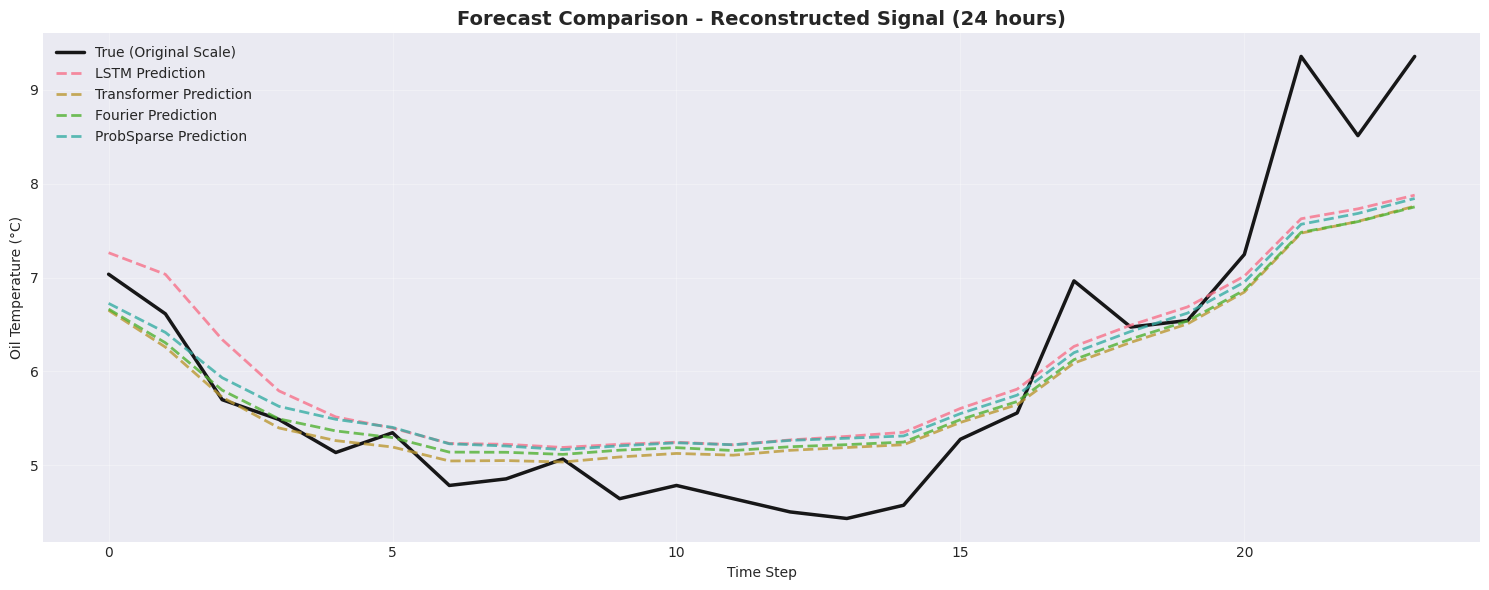


Visualizing multiple test samples...


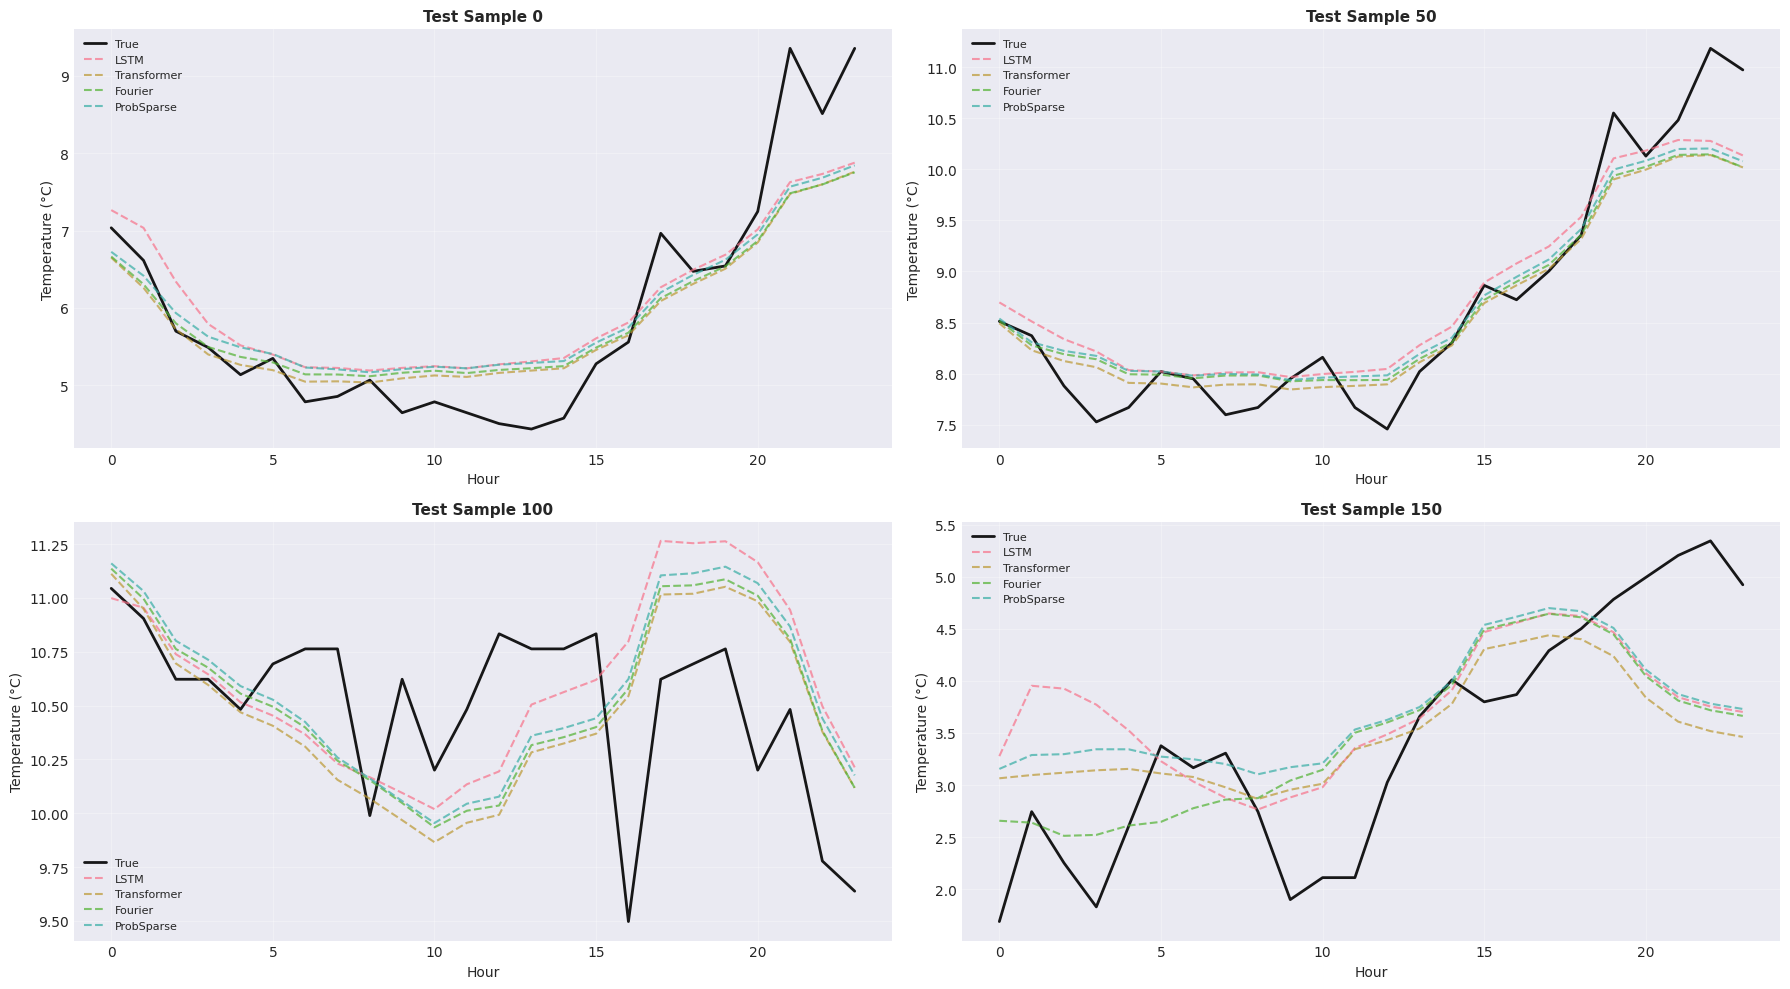

In [12]:
# Visualizing Forecasts (RECONSTRUCTED - Original Scale)
idx = 0
plt.figure(figsize=(15, 6))
plt.plot(results['LSTM']['y_true'][idx].flatten(), label='True (Original Scale)', color='black', linewidth=2.5, alpha=0.9)
for name, res in results.items():
    plt.plot(res['preds'][idx].flatten(), label=f'{name} Prediction', linestyle='--', linewidth=2, alpha=0.8)
plt.legend(loc='best', fontsize=10)
plt.title('Forecast Comparison - Reconstructed Signal (24 hours)', fontsize=14, fontweight='bold')
plt.ylabel('Oil Temperature (°C)')
plt.xlabel('Time Step')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Additional: Plot multiple samples
print("\nVisualizing multiple test samples...")
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
axes = axes.flatten()

sample_indices = [0, 50, 100, 150]  # Different test samples

for ax_idx, sample_idx in enumerate(sample_indices):
    if sample_idx < len(y_test):
        ax = axes[ax_idx]
        ax.plot(results['LSTM']['y_true'][sample_idx].flatten(), label='True', color='black', linewidth=2, alpha=0.9)
        for name, res in results.items():
            ax.plot(res['preds'][sample_idx].flatten(), label=name, linestyle='--', linewidth=1.5, alpha=0.7)
        ax.set_title(f'Test Sample {sample_idx}', fontsize=11, fontweight='bold')
        ax.set_ylabel('Temperature (°C)')
        ax.set_xlabel('Hour')
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Conclusion

### Multivariate Residual-Only Learning Strategy

This notebook implements **Multivariate Residual-Only Learning** to solve the "seasonal lookup table" problem by providing causal context.

**Key Architecture:**
1. **STL Decomposition**: Separates OT into Trend, Seasonal, and Residual components
2. **Target**: Models learn **only the OT residuals** (the physics-driven fluctuations)
3. **Features**: Models receive **5 input features**:
   - OT Residual (past values of what we're predicting)
   - HUFL, HULL, MUFL, MULL (electrical load - the **cause** of temperature spikes)
4. **Reconstruction**: Predictions reconstructed by adding Trend + Seasonal back

**Why This Works (The Physics):**
- **Problem**: Transformer temperature spikes are caused by electrical load, not time-of-day
- **Univariate Failure**: Without load data, residuals look like random noise → models predict zero
- **Multivariate Solution**: Load features provide the **causal signal** (High Load → High Temp)
- **Result**: Models can now predict "If load spikes at hour 5, temperature will spike at hour 6"

**Expected Performance:**
- **Dramatic Improvement** over univariate baseline
- Transformers should capture load→temperature lag relationships via attention
- Correlation should be significantly higher (>0.8) with load context
- Models should now track the jagged spikes, not just smooth curves

**Model Comparison:**
- **LSTM**: Good at short-term load-temp correlations (1-3 hours)
- **Transformer**: Best at long-range dependencies (load spike → delayed temperature response)
- **Fourier**: Captures periodic load patterns (daily/weekly cycles)
- **ProbSparse**: Efficient attention for long sequences with sparse load events